In [ ]:
#| default_exp s2a_delar_mup_wds_mlang
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import io
import time
import math
import random
import dataclasses

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from fastcore.basics import store_attr
from huggingface_hub import hf_hub_download

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar

In [ ]:
#| export
from whisperspeech import inference
from whisperspeech.modules import *

In [ ]:
from encodec.model import EncodecModel
import webdataset as wds
from whisperspeech.train import *

import pylab as plt
from IPython.display import Audio, HTML, display

# Semantic to acoustic token modeling

### Load the dataset

In [ ]:
#| exporti
def rand(start, end):
    return random.random() * (end - start) + start

def logrand(start, end):
    return 10**rand(math.log10(start), math.log10(end))

In [ ]:
#| exporti
def random_trunc(random_trunc_p, atoks_len = 2250, stoks_len = 750):
    atoks_per_second = atoks_len / 30
    def _trunc(samples):
        for s in samples:
            if random.random() < random_trunc_p:
                seconds = rand(0.3, 30)
                s['atoks.npy'] = s['atoks.npy'][:,:math.ceil(seconds * atoks_per_second)]
            s['stoks.npy'] = s['stoks.npy'][:math.ceil(s['atoks.npy'].shape[-1]/atoks_len*stoks_len)]
            yield s
    return _trunc

def pad_samples(atoks_len = 2250, stoks_len = 750, stoks_pad_token = 4096):
    def _pad(samples):
        for s in samples:
            stoks = torch.tensor(s['stoks.npy'])
            atoks = torch.tensor(s['atoks.npy'])
            s['in_stoks'] = F.pad(stoks, (1, stoks_len - stoks.shape[-1]-1), value=stoks_pad_token)
            q,n = atoks.shape
            padatoks = [F.pad(   atoks[i], (i + 1, 0                    ), value=1025) for i in range(q)]
            padatoks = [F.pad(padatoks[i], (0,     atoks_len - n - i - 1), value=1024) for i in range(q)]
            s['in_atoks'] = torch.stack(padatoks)
            yield s
    return _pad

In [ ]:
#| export
def load_dataset(
        dataset_dir:Path,
        stoks_dir:str="stoks",
        random_trunc_p:float=0,# probability of truncating the input to less than 30 seconds
        vq_codes:int=4096,
        weight:float=1,
        validation:bool=False,
        exclude_datasets:str="atoks-random-valid",
        randomize_speakers:bool=False,
    ):
    import webdataset as wds
    from whisperspeech import utils, languages

    dataset_dir = Path(dataset_dir)
    shards = utils.shard_glob(dataset_dir/'encodec-3kbps/*.tar.gz')
    with open(dataset_dir/'atoks-samples.list') as f: samples = len(f.readlines())
    language = utils.readlines(dataset_dir/'language')[0]

    excludes = {x
                for dir in exclude_datasets.split()
                for x in utils.readlines(dataset_dir/Path(dir)/"atoks-samples.list")
               } if not validation and exclude_datasets else set()
    
    def check_for_nan(s):
        if torch.tensor(s['spk_emb.npy']).isnan().any(): print("found NaN:", s['__key__'])
        return s
    
    def set_language(x):
        x['language'] = languages.to_id(language)
        return x
    
    same_on_all_nodes = lambda urls: urls # will only be used for validation
    ds = wds.WebDataset(shards, resampled=not validation, nodesplitter=same_on_all_nodes).compose(
        wds.decode(),
        utils.merge_in(utils.derived_dataset(stoks_dir)),
        wds.map(check_for_nan),
        wds.select(lambda s: s['__key__'] not in excludes),
        wds.map_dict(**{'spk_emb.npy':np.nan_to_num}), # remove nans from the speaker embedding model
        random_trunc(random_trunc_p) if random_trunc_p > 0 else lambda x: x,
        pad_samples(stoks_pad_token=vq_codes-1),
        wds.map(set_language),
        wds.to_tuple('in_stoks', 'in_atoks', 'spk_emb.npy', 'language'),
        wds.shuffle(20000, initial=20000),
        wds.batched(64),
    )
    if randomize_speakers:
        rng = np.random.default_rng()
        ds = ds.compose(
            wds.map_tuple(None, None, lambda x: rng.permutation(x), None),
        )
    if validation:
        ds = ds.slice(samples // 64)
    ds.total_samples = samples
    ds.weight = weight
    
    return ds

## Model

In [ ]:
import pylab as plt
import fastprogress
import IPython
import numpy as np

class CMLMVisual:
    """Visualize training progress"""
    def __init__ (self, model, masterbar, total_steps):
        self.model = model
        self.masterbar = masterbar
        self.total_steps = total_steps
        self.epochs = total_steps // masterbar.main_bar.total
        
        gs = plt.GridSpec(3, 1, height_ratios=[2,2,1])
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.acc_p = graph_fig.add_subplot(gs[1], sharex=self.loss_p)
        self.acc_p.tick_params('x', labelbottom=False)
        self.lr_p = graph_fig.add_subplot(gs[2], sharex=self.loss_p)
        self.lr_p.tick_params('x', labelbottom=False)
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
        self.acc = np.nan
        self.acc_history = []
        self.pacc_history = []
            
    def show(self):
        self.start_t = time.time()
        self.masterbar.write(["samples", "train", "val", "time"], table=True)
        self.graph_out = display(self.graph_fig, display_id=True)
        self.acc_out = display(IPython.display.HTML(''), display_id=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, acc_p, lr_p = self.loss_p, self.acc_p, self.lr_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(0, self.total_steps)
        loss_p.set_yscale('log')
        acc_p.clear()
        for k in self.acc_history[-1].keys():
            acc_p.plot(self.its, [x[k] for x in self.acc_history], ':')
        lr_p.clear()
        lrs = np.array(self.lr_history)
        lr_p.plot(self.its, lrs)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        metrics = self.model.get_metrics()
        self.acc_history.append(metrics)
        html  = "<h5>Accuracies:</h5><table>"
        html += "<thead>"+(''.join([f"<td>{k}<td>" for k,x in metrics.items()]))+"</thead>"
        html += "<tr>"+(''.join([f"<td>{x*100:.1f}%<td>" for k,x in metrics.items()]))+"</tr>"
        html += "</table>"
        self.acc_out.update(IPython.display.HTML(html))
        self.plot()

    def add_table_row(self, it, avg_train_loss, val_loss):
        elapsed_t = time.time() - self.start_t
        self.masterbar.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", fastprogress.core.format_time(elapsed_t)], table=True)
    
    def on_iter(self, bar, it, avg_train_loss, val_loss):
        epoch = math.ceil(it / self.total_steps * self.epochs)
        bar.comment = f"#{epoch}/{self.epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f}"

In [ ]:
#| export
class DelSumEmbedding(nn.Module):
    def __init__(self, n_head=6, head_width=64, atoks_width=None, length=2250, codes=1024, quantizers=8, pos_embs=None):
        super().__init__()
        self.length = length
        width = n_head * head_width
        if atoks_width is None: atoks_width = width
        self.width = width
        self.quantizers = quantizers

        emb = None
        embs = []
        for _ in range(quantizers):
            emb = FlexEmbeddings(codes, width, special_codes=2, frozen_width=atoks_width,
                                 special_embedding=emb and emb.special)
            embs.append(emb)
        self.embeddings = nn.ModuleList(embs)
        if pos_embs is not None:
            self.register_buffer("positional_embedding", pos_embs)

    def forward(self, toks, xenc):
        with record_function("embeddings"):
            b,_,n = toks.shape
            newn = min(n, self.length)

            embs = torch.zeros((b,newn,self.width), dtype=xenc.dtype, device=xenc.device)
            for i in range(self.quantizers):
                embs[:, :] += self.embeddings[i](toks[:,i,:])
            
            x = embs.to(xenc.dtype)
        return x

In [ ]:
#| export
class DelSumHead(nn.Module):
    def __init__(self, quantizers=8, n_head=6, head_width=64):
        super().__init__()
        self.width = n_head * head_width
        self.quantizers = quantizers
        self.splitter = nn.Sequential(
            nn.Linear(self.width, self.width * quantizers),
            nn.GELU(),
        )

    def forward(self, x, embeddings=None):
        b, newn, _ = x.shape
        with record_function("splitter"):
            split = self.splitter(x).view(b,newn,self.quantizers,self.width)
        with record_function("unembed"):
            logits = torch.stack([embeddings[q].unembed(split[:,:,q]) for q in range(self.quantizers)], dim=1)
        return logits
        
def rand(start, end):
    return random.random() * (end - start) + start
    
@dataclasses.dataclass
class Tunables:
    init_std :float = 9
    embeddings_std :float = 0.2
    embeddings_lr_scale: float = 10
    output_mult :float = 5.6
    # FIXME: try separate mults for self and cross attention
    query_mult :float = .3
    encoder_depth_ratio :float = 0.25
    linear_heads :bool = False
    rope :bool = True
    q0_loss_mult: float = 1
    causal_encoder :bool = False
    
    lr0 :float = 3e-3
    clip_gradient_norm :float = 2
    weight_decay :float = 1e-3
    warmup_steps :float = 2000

    random :bool = False
    random_finetune :bool = False
        
    # backwards compat
    force_hidden_to_emb: bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = 2*10**rand(0,1)
            self.embeddings_std = 10**rand(-1.7,-0.22)
            self.embeddings_lr_scale = 2**rand(2,4)
            self.output_mult = 2**rand(1.5,3)
            self.query_mult = 2**rand(-3,-1.3)
            self.encoder_depth_ratio = random.choice([0.25,0.5])
            self.linear_heads = False
            self.rope = True
            
            self.lr0 = 3e-3
            self.clip_gradient_norm = 10**rand(-1,1)
            self.warmup_steps = 100*(10**rand(1.18,1.3))
        if self.random_finetune:
            self.lr0 = logrand(1e-5,1e-3)
            self.clip_gradient_norm = logrand(1e-2,2e-1)
            self.weight_decay = logrand(1e-5,1e-1)
            self.warmup_steps = logrand(20,500)
            
    @staticmethod
    def upgrade(args):
        args = {k:v for k,v in args.items()}
        def old_default(name, value):
            if name not in args: args[name] = value
        old_default('rope', False)
        old_default('linear_heads', True)
        old_default('causal_encoder', False)
        old_default('force_hidden_to_emb', True)
        return args
            
class SADelARTransformer(nn.Module):
    def __init__(self, depth=3, ctx_n=2250,
                 stoks_len=750, stoks_codes=4097, stoks_width=None,
                 spk_width=None,
                 atoks_width=None,
                 n_head=3, head_width=64, ffn_mult=4,
                 quantizers=8, speaker_map={"1":0}, tunables=Tunables()):
        super().__init__()
        self.quantizers = quantizers
        self.codes = 1024
        width = n_head * head_width
        store_attr("depth,ctx_n,stoks_len,stoks_codes,stoks_width,spk_width,atoks_width,n_head,head_width,ffn_mult,quantizers,speaker_map")
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables
        
        if stoks_width is None: stoks_width = width
        if spk_width is None: spk_width = width
        self.emb_factor = width != stoks_width
        self.spk_factor = width != spk_width

        if tunables.rope:
            self.positional_embeddings = None
        else:
            self.register_buffer('positional_embeddings', sinusoids(ctx_n, width))

        self.semantic_embedding = nn.Embedding(stoks_codes, stoks_width)
        if self.emb_factor:
            self.emb_to_hidden = nn.Linear(stoks_width, width)
            if self.tunables.causal_encoder or self.tunables.force_hidden_to_emb:
                self.hidden_to_emb = nn.Linear(width, stoks_width)
        
        if self.spk_factor:
            self.spk_to_hidden = nn.Linear(spk_width, width)

        qk_scale = self.tunables.query_mult * 8 / math.sqrt(head_width)
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        self.encoder = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head, qk_scale=qk_scale, ffn_mult=ffn_mult, rope=tunables.rope) for _ in range(encoder_depth)
        ])
        self.ln_post = LayerNorm(width)

        self.embds = DelSumEmbedding(
            pos_embs=self.positional_embeddings, length=ctx_n,
            n_head=n_head, head_width=head_width, atoks_width=atoks_width,
            quantizers=quantizers,
        )
        self.decoder = BaseDecoder(qk_scale=qk_scale, length=ctx_n,
                                     n_head=n_head, width=n_head * head_width, 
                                     ffn_mult=ffn_mult, depth=decoder_depth,
                                     rope=tunables.rope)
        self.head = DelSumHead(n_head=n_head, head_width=head_width, quantizers=quantizers)
        for l in self.decoder.layers:
            l.cross_attn.key_subsampling = 3
        
        self.register_buffer('val_true', torch.zeros(self.quantizers))
        self.register_buffer('val_total', torch.zeros(self.quantizers))
        self.apply(self.init_transformer)

    def setup(self, device):
        pass
        
    def load_frozen_semantic_embeddings(self, vqmodel):
        with torch.no_grad():
            self.semantic_embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
            self.semantic_embedding.lr_scale = 0

    def load_frozen_acoustic_embeddings(self, amodel):
        for i in range(self.quantizers):
            self.decoder.embeddings[i].set_frozen_embeddings(amodel.quantizer.vq.layers[i].codebook)
            
    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)

    def embed_stoks(self, Stoks):
        b,n = Stoks.shape
        if self.stoks_len == 1500:
            # converts 50 toks/s to 75 toks/s by adding padding between every two tokens
            x = Stoks.reshape(b,n//2,2)
            x = x.repeat_interleave(2, -1)[:,:,:3]
            x[:,:,1] = 1024
            x = x.reshape(b,n//2*3)
        else:
            # it's a lot easier with 25 toks/s
            x = Stoks
        # embed semantic tokens
        Sembs = self.semantic_embedding(x.to(torch.long))
        if self.emb_factor:
            Sembs = self.emb_to_hidden(Sembs)
        return Sembs

    def _encoder(self, semb, positions):
        x = semb
        for l in self.encoder: x = l(x, positions, causal=self.tunables.causal_encoder)
        return self.ln_post(x)
    
    def run_encoder(self, Stoks, speakers):
        semb = self.embed_stoks(Stoks)
        with record_function("encoder"):
            if self.positional_embeddings is not None: semb = semb + self.positional_embeddings
            positions = torch.arange(0, semb.shape[1], device=semb.device)
            xenc = self._encoder(semb, positions)
        if self.training and self.tunables.causal_encoder:
            enc_logits = (self.hidden_to_emb(xenc) @ self.semantic_embedding.weight.to(xenc.dtype).T).float()
            enc_logits = enc_logits * self.tunables.output_mult / (self.width / self.base_width)
        else:
            enc_logits = None

        spk_embs = F.normalize(speakers, dim=-1) # use extracted embeddings
        if self.spk_factor: spk_embs = self.spk_to_hidden(spk_embs)
        return xenc + spk_embs.unsqueeze(1), positions, enc_logits

    def forward(self, Stoks, Atoks, speakers, langs=None, out_stoks=None, out_atoks=None, noloss=False, xenc=None, xenc_positions=None, atoks_positions=None):
        if xenc is None:
            Stoks, Atoks = [x.to(dtype=torch.long) for x in (Stoks, Atoks)]
            xenc, xenc_positions, enc_logits = self.run_encoder(Stoks, speakers)
        with record_function("decoder"):
            embs = self.embds(Atoks, xenc)
            if atoks_positions is None: atoks_positions = torch.arange(0, embs.shape[1], device=embs.device)
            x = self.decoder(embs, atoks_positions, xenc, xenc_positions)
            logits = self.head(x, embeddings=self.embds.embeddings)
            logits *= self.tunables.output_mult / (self.width / self.base_width)
            
        if noloss:
            return logits

        with record_function("loss"):
            loss = 0
            for i in range(self.quantizers):
                loss += F.cross_entropy(logits[:,i,:-1].reshape(-1,logits.shape[-1]), Atoks[:,i,1:].reshape(-1), ignore_index=1024)
                if self.training and i == 0:
                    loss *= self.tunables.q0_loss_mult
            loss_denom = self.quantizers
            if self.training: loss_denom += - 1 + self.tunables.q0_loss_mult
            loss /= loss_denom
            if self.training and self.tunables.causal_encoder:
                loss += 0.1 * F.cross_entropy(enc_logits[:,:-1].transpose(-1,-2), Stoks[:,1:])

        if not self.training:
            for i in range(self.quantizers):
                Atoks_i = Atoks[:,i,1:]
                valid_Atoks = Atoks_i != 1024
                self.val_true[i] += (logits[:,i,:-1].argmax(-1)[valid_Atoks] == Atoks_i[valid_Atoks]).float().sum()
                self.val_total[i] += valid_Atoks.float().sum()

        return logits, loss

    def get_metrics(self):
        metrics = {
            f'acc_{i}':x.item() for i,x in enumerate(self.val_true / self.val_total)
        }
        self.val_true[:] = 0
        self.val_total[:] = 0
        return metrics

    #
    # inference
    #
    @classmethod
    def load_model(cls, ref="collabora/whisperspeech:s2a-q4-small-en+pl.model",
                   repo_id=None, filename=None, local_filename=None, spec=None, device=None):
        if repo_id is None and filename is None and local_filename is None and spec is None:
            if ":" in ref:
                repo_id, filename = ref.split(":", 1)
            else:
                local_filename = ref
        if not local_filename and spec is None:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        if spec is None:
            spec = torch.load(local_filename, map_location=device)
        if '_extra_state' not in spec['state_dict'] and 'speaker_map' in spec['config']: spec['state_dict']['_extra_state'] = { 'speaker_map': spec['config']['speaker_map'] }
        model = cls(**spec['config'], tunables=Tunables(**Tunables.upgrade(spec['tunables'])))
        model.load_state_dict(spec['state_dict'])
        model.eval().to(device)
        return model
    
    def get_extra_state(self):
        return { 'speaker_map': self.speaker_map }
    
    def set_extra_state(self, st):
        self.speaker_map = st['speaker_map']

    def load_checkpoint(self, local_filename_or_obj):
        if isinstance(local_filename_or_obj, (str, Path)):
            spec = torch.load(local_filename_or_obj, map_location='cpu')
        else:
            spec = local_filename_or_obj
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self
    
    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    def switch_dtypes(self, dtype=torch.float16):
        self.dtype = dtype
        for n,m in self.named_modules():
            # convert every leaf layer apart from the LayerNorms
            if isinstance(m, (nn.Linear, nn.Embedding)):
                m.to(dtype)
            # take care of buffers ([kv]_cache, masks) that are not in the leaf layers
            for bn,b in m.named_buffers(recurse=False):
                setattr(m,bn,b.to(dtype))

    def optimize(self, max_batch_size=1, dtype=torch.float16, torch_compile=True):
        for emb in self.embds.embeddings:
            emb.convert_for_eval()
        for l in self.encoder:
            l.attn.convert_for_eval()
        for l in self.decoder.layers:
            l.attn.convert_for_eval()
            l.cross_attn.convert_for_eval()
            l.setup_kv_cache(max_batch_size, self.ctx_n, self.stoks_len)
        self.switch_dtypes(dtype)
        if torch_compile:
            self.generate_next = torch.compile(self.generate_next, mode="reduce-overhead", fullgraph=True)
            
    def optimize_training(self):
        self.decoder = torch.compile(self.decoder, fullgraph=True, mode="reduce-overhead")
        self._encoder = torch.compile(self._encoder, fullgraph=True, mode="reduce-overhead")

    @property
    def device(self):
        return next(self.parameters()).device

    def generate_one(self, toks, positions, langs, xenc, xenc_positions, T, top_k):
        probs = self(None, toks, None, langs, noloss=True, xenc=xenc, xenc_positions=xenc_positions, atoks_positions=positions)
        probs = probs[:,:,-1]
        return inference.sample(probs, T, top_k)

    def generate_next(self, *args, **kwargs):
        return self.generate_one(*args, **kwargs)
    
    @torch.no_grad()
    def generate(self, stoks, speakers, langs=None, atoks_prompt=None, N=None, bs=1, T=0.7, top_k=None, show_progress_bar=True, step=None, subsample_enc=False):
        dev = self.device
        N = N or len(stoks) * 3
        stoks = F.pad(stoks.to(dev), (1, self.stoks_len - len(stoks) - 1), value=self.stoks_codes-1).unsqueeze(0)
        speakers = speakers.to(device=dev, dtype=self.dtype)
        toks = torch.full((bs,self.quantizers,self.ctx_n), self.codes+1, dtype=torch.long, device=dev)
        T = torch.tensor(T, device=dev)

        start = 0 # number of valid tokens or the index of first empty spot
        if atoks_prompt is not None:
            start = atoks_prompt.shape[-1]
            for i in range(self.quantizers):
                toks[:,i,1+i:start+i+1] = atoks_prompt[:,i]
        start += 1 # we always start with at least an SOT

        with record_function("encode"):
            stoks, speakers = [x.repeat(bs, 1) for x in (stoks, speakers)]
            xenc, xenc_positions, _ = self.run_encoder(stoks, speakers)
            toks_positions = torch.arange(N, device=dev)
        with record_function("prefill"):
            initial = self.generate_one(toks[:,:,:start], toks_positions[:start], langs, xenc, xenc_positions, T, top_k)
            toks[:,:start,start:start+1] = initial[:,:start]
            start += 1
            
        with inference.inference_context():
            it = range(start,min(N,self.ctx_n-1))
            if show_progress_bar: it = progress_bar(it)

            for i in it:
                with record_function("generate_one"):
                    toks[:,:i,i:i+1] = self.generate_next(toks[:,:,i-1:i], toks_positions[i-1:i], langs, xenc, xenc_positions, T, top_k)[:,:i]

                # for profiling, debugging or early exit
                if step is not None: step()
        # shift tokens
        toks = toks[:,:,1:N]
        for j in range(self.quantizers):
            toks[:, j] = torch.roll(toks[:, j], -j)
        return toks[:,:,:N-4]

In [ ]:
#| exporti
def _make_model(size:str, quantizers:int=4, tunables:Tunables=Tunables(), **kwargs):
    kwargs = dict(quantizers=quantizers, tunables=tunables, **kwargs)
    if size == 'micro':
        return SADelARTransformer(depth=4, n_head=3, ffn_mult=2, **kwargs)
    if size == 'tiny-narrow':
        return SADelARTransformer(depth=4, n_head=6, ffn_mult=1, **kwargs)
    if size == 'tiny':
        return SADelARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return SADelARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'base-deep':
        return SADelARTransformer(depth=9, n_head=8, **kwargs)
    if size == 'base-wide':
        return SADelARTransformer(depth=6, n_head=12, **kwargs)
    if size == 'small/2':
        return SADelARTransformer(depth=9, n_head=12, **kwargs)
    if size == 'small':
        return SADelARTransformer(depth=12, n_head=12, **kwargs)
    if size == 'medium':
        return SADelARTransformer(depth=24, n_head=16, **kwargs)

def make_model(size:str, quantizers:int=4, frozen_embeddings_model:str=None, frozen_acoustic_embeddings:bool=False, spk_width:int=None, tunables:Tunables=Tunables(), dataset=None):
    from encodec.model import EncodecModel
    from whisperspeech import vq_stoks

    amodel = EncodecModel.encodec_model_24khz() if frozen_acoustic_embeddings else None
    vqmodel = vq_stoks.RQBottleneckTransformer.load_model(frozen_embeddings_model) if frozen_embeddings_model else None
    model = _make_model(size, quantizers, tunables,
                        spk_width=spk_width,
                        atoks_width=amodel and amodel.quantizer.vq.layers[0]._codebook.embed.shape[-1],
                        stoks_codes=vqmodel.vq_codes+1, stoks_width=vqmodel.rq.layers[0]._codebook.embed[0].shape[-1])
    if vqmodel: model.load_frozen_semantic_embeddings(vqmodel)
    if amodel: model.load_frozen_acoustic_embeddings(amodel)
    return model

def load_model(*args, **kwargs):
    return SADelARTransformer.load_model(*args, **kwargs)

## Training test

In [ ]:
train_ds = load_dataset('../librilight/*atoks*.tar.gz', '../librilight-vq-en+pl/', 100000, vq_codes=513, exclude_files='../librilight/common-speakers-maxvad')
val_ds = load_dataset('../librilight/common-speakers-maxvad.tar.gz', '../librilight-vq-en+pl/', 512, vq_codes=513, validation=True)

samples,train,val,time
25024,3.95886,4.17079,02:34
50016,3.71909,3.81947,04:56
75008,3.53838,3.62924,07:18
100000,3.34118,3.46100,09:39


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


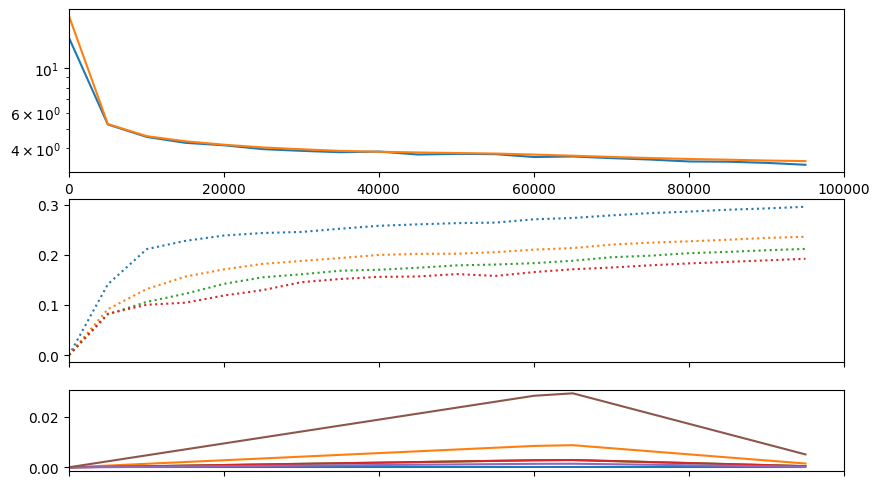

In [ ]:
model = make_model('micro', quantizers=4, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model',
                   tunables=Tunables()).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=25000, run_valid_every_iters=5000, visual_class=CMLMVisual)

samples,train,val,time
25024,4.16333,4.16063,02:32
50016,3.98411,3.79632,04:55
75008,3.75278,3.62357,07:18
100000,3.54639,3.45734,09:41


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


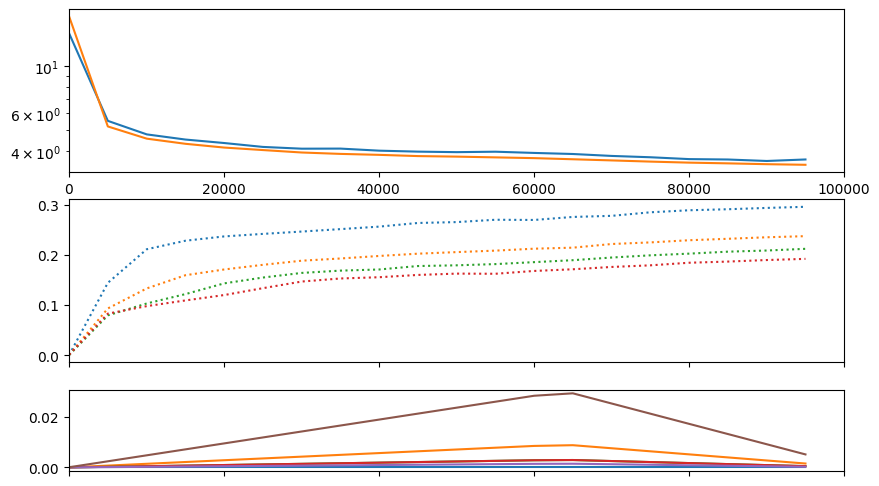

In [ ]:
# encoder loss barely helps, probably because the RoPE cross-attention bias is already helping a lot
model = make_model('micro', quantizers=4, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model',
                   tunables=Tunables(causal_encoder=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=25000, run_valid_every_iters=5000, visual_class=CMLMVisual)

samples,train,val,time
25024,3.59923,4.24838,02:32
50016,3.41711,3.88030,04:55
75008,3.19359,3.70881,07:17
100000,3.04986,3.53762,09:39


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


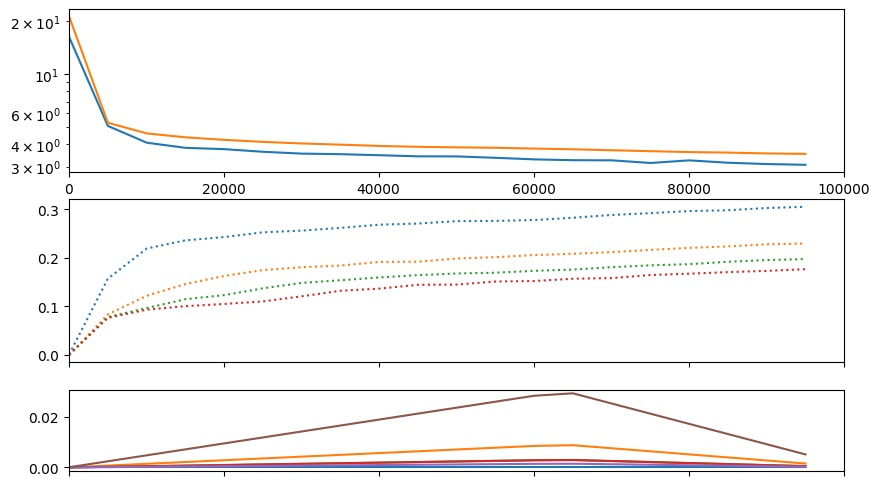

In [ ]:
# we can prioritize the loss for the first quantizer
# we'd have to compare generations to really know if it helps though
model = make_model('micro', quantizers=4, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model',
                   tunables=Tunables(q0_loss_mult=5)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=25000, run_valid_every_iters=5000, visual_class=CMLMVisual)